### Motivation for Work
During my senior year of college, I completed a thesis in which I analyzed Baryon Acoustic Oscillations: particular patterns of distributions of galaxy in space. Here, the focus is on the Python code used to do the analysis. Although this document was not part of my original write-up for my thesis, I thought it would be a good idea to add some notes on the code. The code will explained, though there will be little explanation of background knowledge. So, if you're interested in why this research was conducted, and are looking for a more in depth account of the theory behind this work, I encourage you to look through [my thesis](https://wkwako.github.io/images/Kwako_Thesis.pdf)! I would be happy to answer any questions you may have about either the research or the coding behind it. My contact info can be found on [my website](https://wkwako.github.io/).

### Introduction to BAOs and the Data Set 

Baryon Acoustic Oscillations (BAOs) are, as I described above, a particular arrangement of galaxies in space. Their cause is significantly more complicated and explained wholly in my thesis, but not knowing the cosmological background necessary to understand their origin will not inhibit comprehension of the code.

An artist's rendition of BAOs is shown below [3].
![title](images/BAO_artist's_representation.jpg)
A BAO is characterized by a dense spherical shell of galaxies surrounding a very dense core of galaxies. Each BAO is on the scale of hundreds of megaparsecs (1Mpc ~ 3 million lightyears). Note that unlike the picture, BAOs are three-dimensional, and are not as pronounced as shown.

We searched for BAOs in a density field constructed from the 2MASS Redshift Survey (2MRS) [4], created by cosmographer Brent Tully [7]. Redshift surveys are large-scale galactic "maps" whose purpose lies in charting vast regions of space. This particular data set gives us the location of approximately 19 million regions of density. We use the wavelet transformation to locate and analyze these perturbations. This method was first proposed by P. Arnalte et al in 2012 in an attempt to analyze BAOs in the Sloan Digital Sky Survey [9] [1].

### The Data in a More Usable Form
If we import the data as convert it to a pandas dataframe, we can take a brief look at it before diving into the analysis.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate

In [2]:
farray=pd.read_table('C:\\Users\\Will\\Documents\\Summer_Watkins_Research\\2mrs1175den.speck', \
                     header=None, sep='\s+')
farray.columns= ['x','y','z','r','logd','d'] #labeling the columns of the imported data

print ("first five entries:\n" , farray.head())
print ("\n")
print ("last five entries:\n" , farray.tail())

first five entries:
        x      y     z      r   logd          d
0 -199.5 -136.5 -33.5  244.0  5.452   283000.0
1 -199.5 -136.5 -32.5  243.9  5.707   509000.0
2 -199.5 -136.5 -31.5  243.8  5.942   875000.0
3 -199.5 -136.5 -30.5  243.6  6.158  1440000.0
4 -199.5 -136.5 -29.5  243.5  6.355  2270000.0


last five entries:
               x      y     z      r   logd          d
18609693  199.5  144.5 -32.5  248.5  6.844  6980000.0
18609694  199.5  144.5 -31.5  248.3  6.631  4280000.0
18609695  199.5  144.5 -30.5  248.2  6.402  2520000.0
18609696  199.5  144.5 -29.5  248.1  5.899   793000.0
18609697  199.5  144.5 -28.5  248.0  5.649   445000.0


Above, we print the first five entries and the last five entries in the data set. Each location has an associated $(x,y,z)$, total distance r, a density, and a log10 density, where density is in units of solar masses/Mpc$^3$. We found that the most ideal way to organize this data was to put it in a form that most resembles its spacial arrangement: a three dimensional array. By shifting the origin of the data set from the center to a corner, we can convert the data set to a three dimensional array, where each $x$, $y$, and $z$ value represents an index rather than a distance.

In [ ]:
xd = farray.x  #list of x-coordinates
yd = farray.y  #list of y-coordinates
zd = farray.z  #list of z-coordinates
dd = farray.d  #list of densities associated with coordinate points.
               #note that we don't care about the log10 density

Box = np.zeros((400, 400, 400)) #skeleton of three dimensional array

#Defines our coordinate points to start at (0,0,0)
i = 0
j = 0
k = 0

#Creates a 400 by 400 by 400 array where ach element is the density of an (x,y,z)
for n in np.arange(0, len(xd)): #converts to 0 through 400 instead of -200 through 200
    i = int(xd[n] + 199.5)  #Note that we add +199.5 to i,j,k to start each index at 0
    j = int(yd[n] + 199.5)  
    k = int(zd[n] + 199.5)
    Box[i,j,k] = dd[n]

In [3]:
#pickled result of above
Q = open('D:\\extra_python_files\\Box_Will.pkl', 'rb')
Box = pickle.load(Q)

Notice that we first initialize a separate variable for each relevant column in our pandas dataframe. Then, we import numpy and create the three dimensional array. Lastly, we fill each element of our three dimensional array (named Box) with its corresponding density. This step can also be thought of a coordinate transformation, one that shifts the range of our values from -199.5 to 199.5, to 0 to 399. Now, each $x$, $y$, $z$ represents an index, with a single $(x,y,z)$ picking out the corresponding density at the specified variables. Each coordinate point is separated by one integer step, giving each each grid-point an associated density. Since this data set is 400 by 400 by 400, there are 64 million points total. That's quite a few! Note, however, that because the 2MRS is spherically shaped and our array is a cube, the corners of the cube will have a density of zero.

### The Density Contrast

Instead of working with density values in solar masses/Mpc$^3$, we would prefer working with an absolute scale - one that is easier to analyze and more purposefully scaled to our needs. We introduce the density contrast, given by the equation
\begin{align}
\delta(\bf{r}) = \frac{\rho(\bf{r}) - \rho_0}{\rho_0},
\end{align}
where $\rho(\bf{r})$ is the density at a single location, and $\rho_0$ is the average density. Conceptually, the density contrast gives us the difference between the average density and the density of any sampled point. Since we're only looking for patterns in density by comparing regions of space to each other, we don't need to bother with density in terms of solar masses. Therefore, we redefine our data set in terms of the density contrast. Note that regions of zero density now read as $-1$.

In [4]:
δ = (Box - np.mean(Box))/np.mean(Box) #density contrast

### Visualizing the Data

We plot a slice of the data using matplotlib's imshow command. I plot three different slices, each of which contain the point $(200,200,200)$, but from a different plane.

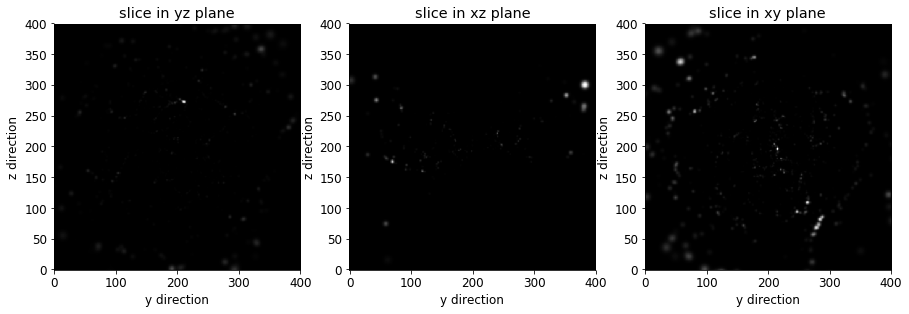

In [9]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(15,15))

plt.subplot(131)
plt.xlabel('y direction')
plt.ylabel('z direction')
plt.imshow(δ[200,:,:], cmap = 'Greys_r', origin = 'lower left')
plt.title('slice in yz plane')

plt.subplot(132)
plt.xlabel('y direction')
plt.ylabel('z direction')
plt.imshow(δ[:,200,:], cmap = 'Greys_r', origin = 'lower left')
plt.title('slice in xz plane')

plt.subplot(133)
plt.xlabel('y direction')
plt.ylabel('z direction')
plt.imshow(δ[:,:,200], cmap = 'Greys_r', origin = 'lower left')
plt.title('slice in xy plane')

plt.show()

In each of the above images, the white clumps represent galaxy groups and are regions of high density. There are far fewer regions of high density than of low density, as indicated by the sparse density clumps.

### The Wavelet Transformation

The wavelet transformation aims to mathematically model the density distribution of a BAO, then search the data set for regions that resemble the model. In this way, we are able to filter the BAO signal through our data, successfully locating their positions. The wavelet we used, first proposed by P. Arnalte et al in 2012 [9], has its radial profile given by the equation
\begin{align}
\psi_{R,s}(r) = \frac{\alpha_{R,s}}{4\pi r^2} \Big( 2B_3 \Big( 2\frac{r-R}{s} \Big) - B_3 \Big(\frac{r-R}{s} \Big) \Big),
\end{align}
where $\alpha_{R,s}$ is a normalization constant, $R$ and $s$ are the characterizing parameters of the wavelet and determine its shape, and $B_3$ is the box spline of the third degree, defined as 
\begin{align}
B_3(x) = \frac{1}{12} \bigg(|x-2|^3 - 4|x-1|^3 + 6|x|^3 - 4|x+1|^3 + |x+2|^3 \big).
\end{align}
There's a lot of theory to unpack in these two equations, but the bulk of the concepts can be summarized fairly succinctly. The most important bit are the two defining parameters of the shape of the wavelet, $R$ and $s$. The radius of the wavelet, $R$, controls the distance from its epicenter to its outer shell, while the width, $s$, determines the thickness of the shell. Below, we define both functions and plot a one-dimensional and three-dimensional wavelet.


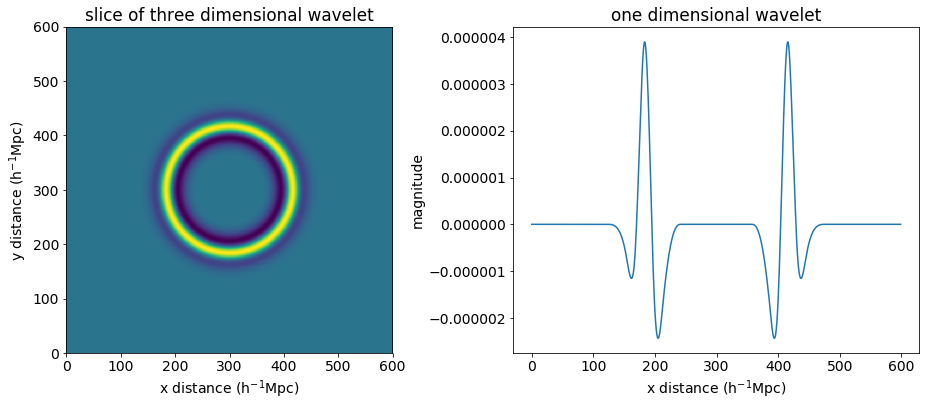

In [10]:
def B_3(x): #B-spline of the third degree. These are added together to create the wavelet profile
    return 1/12*(abs(x-2)**3 - 4*abs(x-1)**3 + 6*abs(x)**3 - 4*abs(x+1)**3 + abs(x+2)**3)

#creates a meshgrid that the wavelet is placed into
xlist = np.arange(-299.5,300,1)
ylist = np.arange(-299.5,300,1)   
zlist = np.arange(-299.5,300,1)
xa,ya,za = np.meshgrid(xlist,ylist,zlist)
rgrid = np.sqrt(xa**2+ya**2+za**2)

#defining arbitrary values for R and s to get a reasonably nice shaped wavelet
R = 117
s = 30
α_Rs = 1 #just a normalization constant. set equal to one

#the wavelet equation from above
wavelet = α_Rs/(4*np.pi*rgrid**2)*(2*B_3(2*((rgrid-R)/s)) - B_3((rgrid-R)/s))

#updating the font size so the axes look nice
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(wavelet[:,:,300], origin = 'lower left')
plt.title('slice of three dimensional wavelet')
plt.xlabel('x distance (h$^{-1}$Mpc)')
plt.ylabel('y distance (h$^{-1}$Mpc)')

plt.subplot(122)
plt.plot(wavelet[300,300,:])
plt.xlabel('x distance (h$^{-1}$Mpc)')
plt.ylabel('magnitude')
plt.title('one dimensional wavelet')
plt.show()

The wavelet is just a mathematical construction that aims to model the signal for which we are searching. Note that even though our data set has a length of $400h^{-1}$Mpc, we use a length of $600h^{-1}$Mpc when creating our wavelet. The reason is far from obvious, but sets us up for the operation we will perform next.

In our units, $h = 0.7$, and is unitless. It is often inserted in cosmological units when dealing with distance, but can be otherwise ignored.

### Convolutions and the Fourier Transform

Wavelets are normally used to analyze frequencies or wavenumber, and thus sees use in signal processing and decoding in fields such as seismology, musical analysis, and image compression [8]. Here, however, we instead use is as a mathematical construction to model the BAO signal. We "place" wavelets on top of high density points in our data set, and check to see if the shell of the wavelet overlaps with high density regions around the chosen points. The mathematical operation we perform when we "place" a wavelet on top of a region in space is called a convolution. A convolution takes two functions and returns a third function that expresses how one function affects the other. When we convolve the wavelet and a point in our data set, we receive a dimensionless value that represents the amount of overlap between the density distribution of the wavelet and the density distribution of the surrounding space the wavelet with which the wavelet was convolved. In short, the convolution checks for the amount of overlap between the wavelet and a region of space.

Convolutions can be time-consuming to calculate, even for a computer, so instead of performing this operation in the spacial domain, we intead perform it in the wavenumber domain. If domains are unfamiliar to you, it might be helpful to think of the different domains as a change of coordinates. Instead of movement in the Cartesian plane corresponding to spacial movement, it instead corresponds to a change in wavenumber. Fourier transforms are operations performed on functions that switch them from the spacial domain to the wavenumber domain, while inverse Fourier transforms go the other way.

First, we transform both our data and the wavelet to wavenumber space using numpy's fast Fourier transform method. Note that when we transform our data, we increase the size of the data set to 600 in each dimension. Performing a convolution causes each function to wrap around the bounds of the other - in our case, the wavelet will wrap around the sides of the data and bleed into data that has already been convolved, giving us unwanted distortion. To account for this bleeding effect, we zero pad the data set before the convolution. Afterwards, we remove the excess space. The following code performs the convolution.

In [11]:
fft_wavelet = np.fft.fftn(wavelet) #the Fourier transform of the wavelet (now in wavenumber space)
fft_data = np.fft.fftn(δ, s=(600,600,600)) #the Fourier transform of the data. (wavenumber space)

conv = fft_wavelet*fft_data #performs the convolution
conv_i = np.real(np.fft.fftshift(np.fft.ifftn(conv))) #inverse fourier transform. takes us back to
                                                      #the spacial domain
W = conv_i[0:400,0:400,0:400] #changes bounds of space back to length of data set

Conceptually, the variable W is the matching parameter, and gives us a dimensionless number that represents the amount of overlap between the density distribution of the wavelet and the density distribution of the surrounding space. In the following code block, we print several values of the matching parameter, W.

In [14]:
for i in range(4):
    i = i*100
    print (f'W = {round(W[i,i,i],2)} at x = {i}, y = {i}, z = {i}')

maxW = np.max(W)
minW = np.min(W)
maxWcoords = np.where(W == maxW)
minWcoords = np.where(W == minW)
x1,y1,z1 = maxWcoords
x2,y2,z2 = minWcoords

print (f'\nThe largest matching parameter in the data set is W = {round(maxW,2)}, \
occuring at x = {x1[0]}, y = {y1[0]}, z = {z1[0]}')

print (f'The smallest matching parameter in the data set is W = {round(minW,2)}, \
occuring at x = {x2[0]}, y = {y2[0]}, z = {z2[0]}')


W = -0.89 at x = 0, y = 0, z = 0
W = -2.51 at x = 100, y = 100, z = 100
W = 0.36 at x = 200, y = 200, z = 200
W = -2.23 at x = 300, y = 300, z = 300

The largest matching parameter in the data set is W = 8.92, occuring at x = 170, y = 54, z = 184
The smallest matching parameter in the data set is W = -5.73, occuring at x = 186, y = 112, z = 90


A negative value corresponds to an inverse correlation between the density distribution of the wavelet and the point at which it was convolved, while a positive value represents a positive correlation. We would think, then, that the higher the matching parameter, the greater chance of finding a BAO at that location. While this is true, it is not always the case that a high matching parameter corresponds to the discovery of a BAO. The wavelet only consists of a dense shell, and thus does not check for the dense epicenter, characteristic of the BAO signal. To rule out the possibility of large matching parameter values picking out non-BAO locations, we only sample locations above a certain density threshold.

### Determining the Shape of the BAO Signal

Let's take a step back for a moment and re-evaluate our objectives. Our primary goal is to find the locations of all BAOs in our data set. To accomplish this, we must determine the wavelet that best fits the BAO signal. Without a correctly-fitting model, we cannot search for BAOs. We know we have a matching parameter that tells us how well any particular wavelet models the density distribution of the surrounding space it picks out, and we know that BAOs must have dense epicenters. Let us revisit the characterizing paramters of a wavelet: R and s. R represents the radius of the wavelet, and determines the distance from its center to its shell, while s represents the width of the shell. To find the characterizing parameters of the best-fit wavelet, and thus, the characterizing parameters of the BAO, we use the following method:

1. Select values for R and s, and create a wavelet given those parameters.
2. Perform a convolution with a grid-point in the data set and the wavelet, returning the dimensionless matching parameter, $W$.
3. Average the result of the convolutions across all grid-points above a certain density threshold.
4. Repeat the above steps, but vary the R and s values each time.
5. Determine the R and s that yielded the highest average matching parameter.

In step 3, notice that we mention a density threshold. The threshold should significantly limit the number of points we need to average over, while not throwing out locations of any BAOs. 

Below, we create four plots. Firstly, we plot a density threshold vs. the fraction of points in the data set which have larger densities. The upper left plot shows a 1x zoom of this plot, while the upper right and bottom left plots are zoomed-in versions. Secondly, we plot a density threshold vs. the average matching parameter of points above said threshold. The plot is the most interesting - it is clear that as we convolve points of higher and higher density, the average matching parameter increases, indicating the presense of formations that cause shells of galaxies to be detected around locations of higher density.

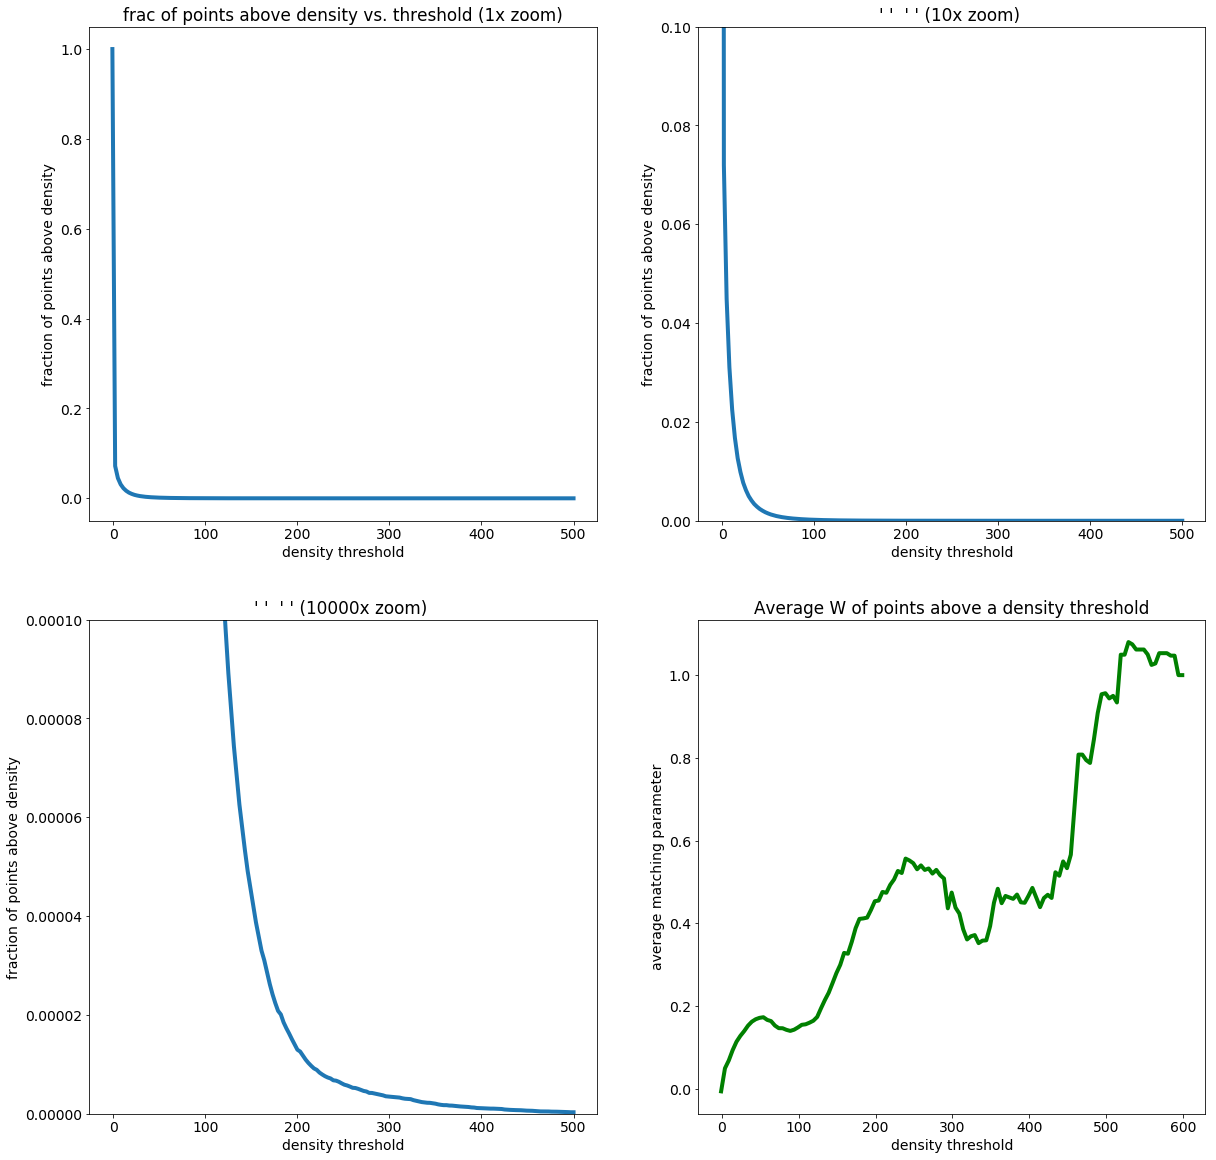

In [17]:
frac = []
thresh_list = []
for i in np.arange(-1,501,3):
    thresh_list.append(i)
    frac.append(np.array((np.where(δ>=i))).shape[1]/(400**3))
    
threshlist = np.arange(-1,601,5)
W_vals_threshlist = []
for i in np.arange(0,len(threshlist), 1):
    W_vals_threshlist.append(np.mean(W[np.where(δ>=threshlist[i])]))

plt.figure(figsize = (20,20))
plt.subplot(221)
plt.plot(thresh_list,frac, linewidth = 4)
plt.ylabel('fraction of points above density')
plt.xlabel('density threshold')
plt.title('frac of points above density vs. threshold (1x zoom)')

plt.subplot(222)
plt.plot(thresh_list,frac, linewidth = 4)
plt.ylim(0,0.1)
plt.ylabel('fraction of points above density')
plt.xlabel('density threshold')
plt.title('\' \'  \' \' (10x zoom) ')

plt.subplot(223)
plt.plot(thresh_list,frac, linewidth = 4)
plt.ylim(0,0.0001)
plt.ylabel('fraction of points above density')
plt.xlabel('density threshold')
plt.title('\' \'  \' \' (10000x zoom) ')

plt.subplot(224)
plt.plot(threshlist, W_vals_threshlist, linewidth = 4, color = 'green')
plt.xlabel('density threshold')
plt.ylabel('average matching parameter')
plt.title('Average W of points above a density threshold')
plt.show()


We don't need to be extremely precise when picking a density threshold, but we should have some analysis backing up our choice. From the first plot, we notice that the amount of points above $\delta = ~150$ really starts to drop off, and from the second, we notice that there is a positive correlation between convolved points of high density, and large matching parameters. We decided on $\delta = 200$ for our initial density threshold.

### R and s Values of the Wavelet

We are now ready to calculate the best-fit R and s values of the wavelet to the BAO signal. Note that the key point here is that __as we approach the best-fit R and s, the average matching parameter will increase, influenced by the presence of BAOs in the data set. Thus, the best-fit R and s will yield the highest average matching parameter of any other R and s.__


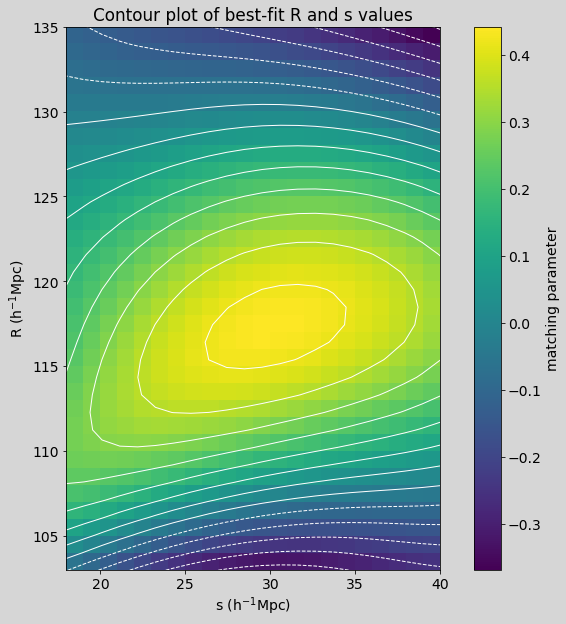

In [10]:
α_Rs = 1

Rlist=np.arange(103,135,1) #list of R values to test
slist=np.arange(18,40,1) #list of s values to test
meangrid=np.zeros((len(Rlist),len(slist)))
for i in range(0,len(Rlist)):
    for j in range(0,len(slist)):
        ψ_Rs = α_Rs/(4*np.pi*rgrid**2)*(2*B_3(2*((rgrid-Rlist[i])/slist[j])) \
                                           - B_3((rgrid-Rlist[i])/slist[j]))            
        fft_wavelet = np.fft.fftn(ψ_Rs)
        conv = fft_wavelet*fft_data
        conv_i = np.real(np.fft.fftshift(np.fft.ifftn(conv)))
        W = conv_i[0:400,0:400,0:400]    
        meangrid[i,j] = np.mean(W[np.where(δ>=200)]) # Finds the average W of all points above
                                                     # δ>200 using the current wavelet parameters
plt.figure(figsize=(12,10))
plt.imshow(meangrid, extent = [18,40,103,135], cmap = 'viridis', origin = 'lower')
plt.colorbar(label = 'matching parameter')
plt.gcf().set_facecolor('#D6D6D6')
plt.contour(meangrid, 13, extent = [18,40,103,135], linewidths=1, colors = 'white', alpha = 1)
plt.xlabel('s (h$^{-1}$Mpc)')
plt.ylabel('R (h$^{-1}$Mpc)')
plt.title('Contour plot of best-fit R and s values')
plt.show()

Above, we plot a contour plot overlayed with a heatmap of our results. On the x-axis, we plot the width of the wavelet, and on the y-axis, we plot the radius. The colorbar on the right side relates the color of the heatmap and the matching parameter of an R and s value. The largest matching parameter seems to occur around s=30 and R=117, but we can calculate the parameters more precisely using the following code:

In [12]:
M = np.where(meangrid == np.max(meangrid)) #the best fit R and s
RM = Rlist[M[0][0]] #Pulls out the best fit R
sM = slist[M[1][0]] #Pulls out the best fit s

print('The characterizing parameters of the wavelet are R =', RM, '\
and s =', sM, 'with units of 1/h Mpc.')

The characterizing parameters of the wavelet are R = 117 and s = 30 with units of 1/h Mpc.


While these results seem to agree with P. Arnalte's results of R = 116 and s = 36 at first glance, we will know for sure if we determine uncertainties for both our values. We plot slices of our contour plot and attempt to fit Gaussians to the curves, picking out the matching Gaussian's standard deviation as our uncertainty.

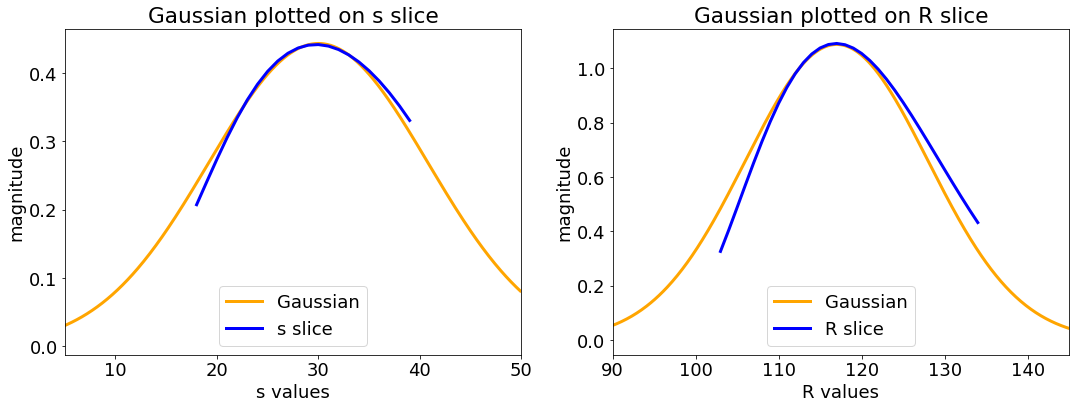

In [20]:
def Gaussian(x,x_0,a):
    """ Gaussian function.
        x is the list of plotted values, x_0 is the mean, a is the uncertainty
    """
    y = (1/(np.sqrt(2*np.pi)*a))*np.exp(-(x-x_0)**2/2/a**2)
    return y

plt.figure(figsize = (18,6))
xlist = np.arange(0,50,.1)
σs = 10.80
plt.subplot(121)
plt.plot(xlist, 12*Gaussian(xlist, 30, σs), linewidth = 3, color = 'orange', label = 'Gaussian') 
plt.plot(slist, meangrid[14,:], linewidth = 3, color = 'blue', label = 's slice')
plt.xlim(5,50)
plt.xlabel('s values')
plt.ylabel('magnitude')
plt.title('Gaussian plotted on s slice')
plt.legend(loc = 'lower center')

xlist = np.arange(0,150,.1)
σR = 11.00
plt.subplot(122)
plt.plot(xlist,  30*Gaussian(xlist, 117, σR), linewidth = 3, color = 'orange', label = 'Gaussian')
plt.plot(Rlist, .65+meangrid[:,12], linewidth = 3, color = 'blue', label = 'R slice')
plt.xlim(90,145)
plt.xlabel('R values')
plt.ylabel('magnitude')
plt.title('Gaussian plotted on R slice')
plt.legend(loc = 'lower center')

plt.show()

Although these are not perfect fits, they give us an idea of what the uncertainties are. Thus, our final results tell us that R = $117$ $\pm$ 11.0h$^{-1}$Mpc and s = $30$ $\pm$ 10.8h$^{-1}$Mpc. These are both within two standard deviations of Arnalte's results, confirmation of the method's success!

### Locations of BAOs

Now that we have determined the parameters that characterize BAOs, we can begin to search for their locations in the data set. This is an entirely separate method from determining their characterizing parameters.

In order for a location in the data set to have the potential to be considered a BAO, it must satisfy two conditions. Firstly, it must have a high matching parameter, as we have discussed above, and secondly, it must have a high density at its center, which we somewhat accounted for in determining the best fit R and s. However, we cannot simply sample all high-density points as we did above - we instead must determine and sample the local maxima.

Determining the local maxima from the original data set is rather difficult, so we first smooth the data. We turn to convolutions, but this time around, convolve the data with a Gaussian instead of a wavelet. The Gaussian acts as a smoothing function, causing local maxima and minima to be more easily detectable.

Below, we plot a slice of the unsmoothed data set vs. the smoothed data. The larger $\sigma$ is, the larger the smoothing effect will be. We fiddled around with the $\sigma$ value, but found $\sigma=4$ to best for our purposes.

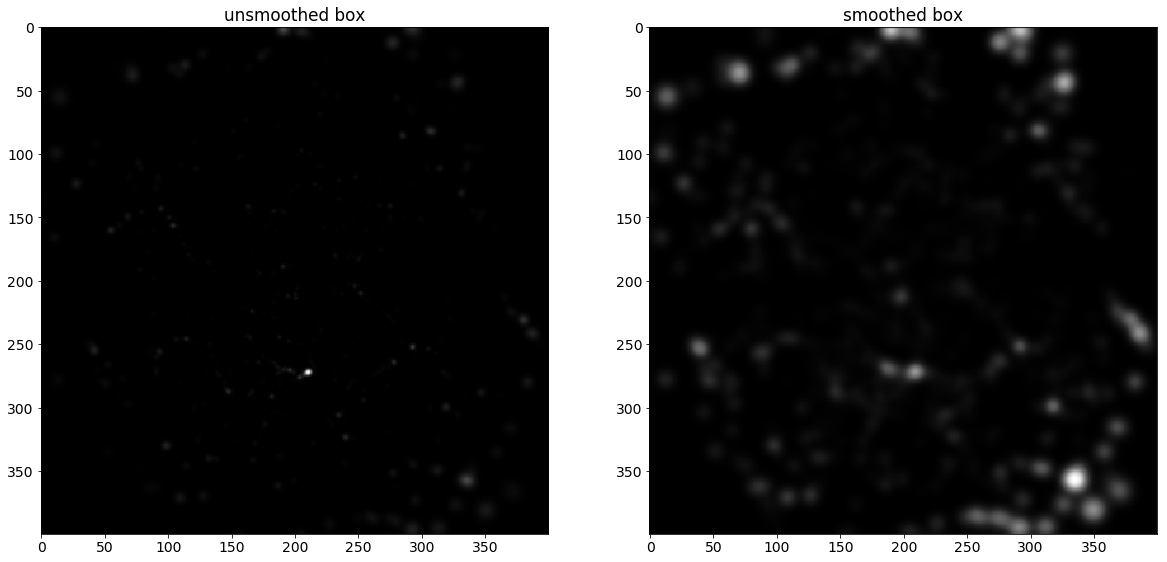

In [20]:
σ = 4 #smoothing is 4. increase for more smooth
G_eqn = np.exp(-rgrid**2/(2*σ**2)) 
G_eqn_Fourier = np.fft.fftn(G_eqn)
conv_Gaussian = fft_data*G_eqn_Fourier
conv_iGaussian = np.real(np.fft.fftshift(np.fft.ifftn(conv_Gaussian)))
Gbox = conv_iGaussian[0:400,0:400,0:400]

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(δ[200,:,:], cmap = 'Greys_r')
plt.title('unsmoothed box')

plt.subplot(122)
plt.imshow(Gbox[200,:,:], cmap = 'Greys_r')
plt.title('smoothed box')
plt.show()

In the above comparison between the unsmoothed data set and the smoothed data set, we can see that the local maxima are significantly more pronounced after performing the convolution with the Gaussian. Next, we locate the local maxima using numpy's roll command. When np.roll() is used on an array, it shifts each element in the specified dimension over one slot. We roll our smoothed Gaussian data set, Gbox, six times, one for each possible movement in three-dimensional space, and store these six rolled data sets in separate variables. If any particular location in Gbox is larger in density than all six rolled versions, it is a local maximum. We store the location of local maxima in a three dimensional array of booleans. By extracting the locations of local maxima and comparing it to the original data set, we can determine their densities. I perform the roll in the following code block.

In [21]:
Box_maxG = np.zeros((400,400,400))
Box_maxG = (Gbox > np.roll(Gbox,1,axis=0)) \
    & (Gbox > np.roll(Gbox,-1,axis=0)) \
    & (Gbox > np.roll(Gbox,1,axis=1)) \
    & (Gbox > np.roll(Gbox,-1,axis=1)) \
    & (Gbox > np.roll(Gbox,1,axis=2)) \
    & (Gbox > np.roll(Gbox,-1,axis=2))

print (f'There are {len(np.where(Box_maxG == True)[0])} locations of local maxima in the data set.')

There are 15766 locations of local maxima in the data set.


Not every local maxima is the epicenter of a BAO, so we filter out the locations that are of no interest to us by applying constraints. Since we know BAOs must have both a dense epicenter and shell, we filter out the points beneath an applied density and matching parameter value threshold. Below, we create two graphs: the first plots the density threshold vs. the number of points greater than each threshold, and the second plots the matching parameter threshold vs. the number of points greater than each threshold. Using these two plots, we can determine appropriate thresholds. __Our goal is to constrain the data as much as possible without excluding any potential BAO locations.__ Note that we use the original data set for this calculation, and not the smoothed version. We opt for using list comprehensions over loops, as they speed up calculations ten fold.

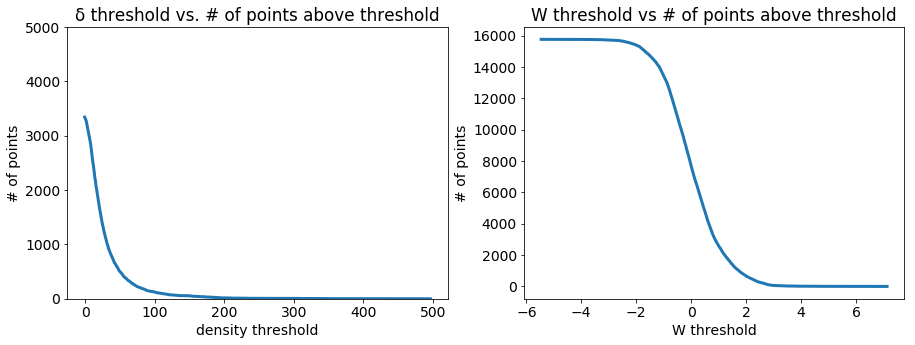

In [35]:
C = np.where(Box_maxG == True)
xs,ys,zs = C

δs = [δ[xs[i],ys[i],zs[i]] for i in range(len(xs))] #creates array of values of local maxima
δs = np.array([δs])[0]
threshListD = np.linspace(np.min(δs),np.max(δs),1000)
aboveThreshD = [len(np.where(δs > threshListD[i])[0]) for i in range(len(threshListD))]

Ws = [W[xs[i],ys[i],zs[i]] for i in range(len(xs))] #creates array of values of local maxima
Ws = np.array([Ws])[0]
threshListW = np.linspace(np.min(Ws),np.max(Ws),1000)
aboveThreshW = [len(np.where(Ws > threshListW[i])[0]) for i in range(len(threshListW))]

#plots the density graph
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(threshListD,aboveThreshD, linewidth = 3)
plt.ylim(0,5000)
plt.title('δ threshold vs. # of points above threshold')
plt.xlabel('density threshold')
plt.ylabel('# of points')

#plots the W graph
plt.subplot(122)
plt.plot(threshListW,aboveThreshW, linewidth = 3)
plt.title('W threshold vs # of points above threshold')
plt.xlabel('W threshold')
plt.ylabel('# of points')
plt.show()

Letting the above graphs lead us toward acceptable thresholds, we experiment with several density and matching parameter values. We end up using a threshold of 60 for our density, and 1.6 for our matching parameter.

In [38]:
densityThresh = 60 #density threshold
WThresh = 1.6 #matching paramter threshold
coords2 = [] 
for i in range(len(C[0])):
    x,y,z = list(zip(xs,ys,zs))[i]
    if δ[x,y,z] > densityThresh and W[x,y,z] > WThresh:
        coords2.append((x,y,z))
print (f'There are {len(coords2)} coordinate points that satisfy the constraints. They are: {coords2}')

There are 43 coordinate points that satisfy the constrains. They are: [(81, 353, 318), (85, 300, 359), (89, 355, 89), (90, 212, 223), (95, 295, 316), (102, 133, 179), (109, 262, 199), (114, 208, 267), (122, 270, 90), (150, 279, 265), (154, 42, 185), (157, 251, 117), (163, 257, 127), (166, 75, 206), (167, 153, 102), (167, 306, 141), (169, 140, 120), (172, 19, 212), (175, 271, 287), (181, 48, 192), (185, 357, 362), (190, 315, 366), (201, 323, 239), (208, 130, 66), (218, 257, 272), (220, 146, 104), (223, 32, 72), (225, 148, 116), (240, 45, 119), (245, 41, 190), (255, 39, 199), (256, 79, 197), (256, 165, 249), (266, 40, 212), (269, 142, 137), (275, 58, 249), (285, 109, 201), (302, 280, 235), (311, 156, 335), (318, 56, 97), (324, 89, 93), (339, 176, 70), (340, 177, 70)]


As we can see, we have significantly lowered the number of viable points by setting a density and matching parameter threshold. Before we begin to analyze these points, we must understand that since these coordinates come from the smoothed data set, it is likely that actual locations of local maxima have been slightly changed. Using the Gaussian to smooth the data set is not a perfect operation, and is likely to cause the maxima locations to shift over a couple of coordinate points. To account for this possible shift, we sample the density of each point in a small radius around each local maxima coordinate point. If a larger density is found, the location is kept and is determined to be the new, correct local maxima.

In [40]:
coords2T = []
for q in range(len(coords2)):
    rpoint = 0
    HD = -2
    x,y,z = coords2[q]
    for i in range(-4,5):
        for j in range(-4,5):
            for k in range(-4,5):
                D = δ[x+i,y+j,z+k]
                if D > HD:
                    rpoint = (x+i,y+j,z+k)
                    HD = D
    coords2T.append(rpoint)
print (f'There are {len(coords2T)} coordinate points that satisfy the constraints. They are: {coords2T}')

There are 43 coordinate points that satisfy the constraints. They are: [(81, 354, 319), (86, 298, 360), (90, 356, 90), (91, 211, 224), (95, 294, 317), (102, 133, 179), (109, 262, 199), (114, 208, 267), (123, 271, 91), (149, 280, 266), (154, 42, 185), (157, 251, 117), (164, 259, 127), (166, 74, 206), (168, 153, 102), (168, 307, 141), (170, 140, 121), (172, 20, 212), (176, 271, 287), (181, 48, 192), (185, 358, 363), (188, 314, 364), (201, 323, 239), (209, 130, 66), (219, 257, 271), (221, 146, 104), (224, 32, 72), (225, 148, 116), (240, 45, 119), (246, 42, 191), (256, 38, 200), (257, 80, 198), (257, 165, 249), (267, 41, 212), (269, 143, 137), (275, 59, 249), (286, 110, 201), (303, 281, 236), (311, 156, 335), (318, 57, 97), (324, 89, 92), (339, 176, 70), (339, 176, 70)]


Most of the coordinate points have changed, though only slightly. Lastly, I notice that the last two coordinate points are the same, so I get rid of one of them.

In [41]:
coords2T = coords2T[:-1]

Although we've narrowed the number of points from 15766 to 42, we still have to manually determine whether or not each point yields evidence of a BAO signal. We plot the radial profile density of each location, which represents how the density varies as we move away from a location. We hope to find graphs that indicate the BAO signal: A highly dense center, whose density decerases as we move radially away, but increases as we pass through the shell. the spike in density on reaching the shell is known as the "BAO bump," and is signature of the BAO signal.

Below, the code determines how the density of each point varies as we move radially away from it. It takes one potential BAO location at a time, and determines, for each R, the sum of the densities of each point along the surface area of the sphere created from the currently selected R.

In [35]:
Rlist = np.arange(1,160,1)
avg_list_pointsT = []
for m in range(len(coords2T)): #"loop runs once for each point"
    avg_onepoint = []
    i_0 = coords[m][0] #set x coord for current point
    j_0 = coords[m][1] #...y coord...
    k_0 = coords[m][2] #...z coord...
    for p in np.arange(0,len(Rlist)): #loop runs once for each element in 'Rlist,' defined above
        d_list = []
        for i in range(-Rlist[p],Rlist[p]): #this loop and the following three select every point along the
            for j in range(-Rlist[p],Rlist[p]):           #circumference of the sphere created by R
                for k in range(-Rlist[p],Rlist[p]): 
                    if i+i_0<0 or j+j_0<0 or k+k_0<0: #if the point is outside the bounds of the data set,
                        continue                      #ignore it
                    if i+i_0>399 or j+j_0>399 or k+k_0>399: 
                        continue
                    d_list.append(δ[i+i_0,j+j_0,k+k_0]) #finds density at one point along perimeter
        avg_onepoint.append(np.mean(d_list)) #averages density of all points along the perimeter for an R
    avg_list_pointsT.append(avg_onepoint) #appends total radial density profile plot of a single point

Now that we have the density of each location as a function of R stored into a single list, we graph each radial profile density plot, color coordinating them depending on whether or not they match the BAO signal. Green plots indicate BAO signals, while red plots do not. Blue plots indicate no correlation with the BAO signal, but are special cases and will be explained below. Three dotted lines are drawn on each graph: the first is a vertical line drawn at the R=100 mark, the second at R=110, and the third at R=120.

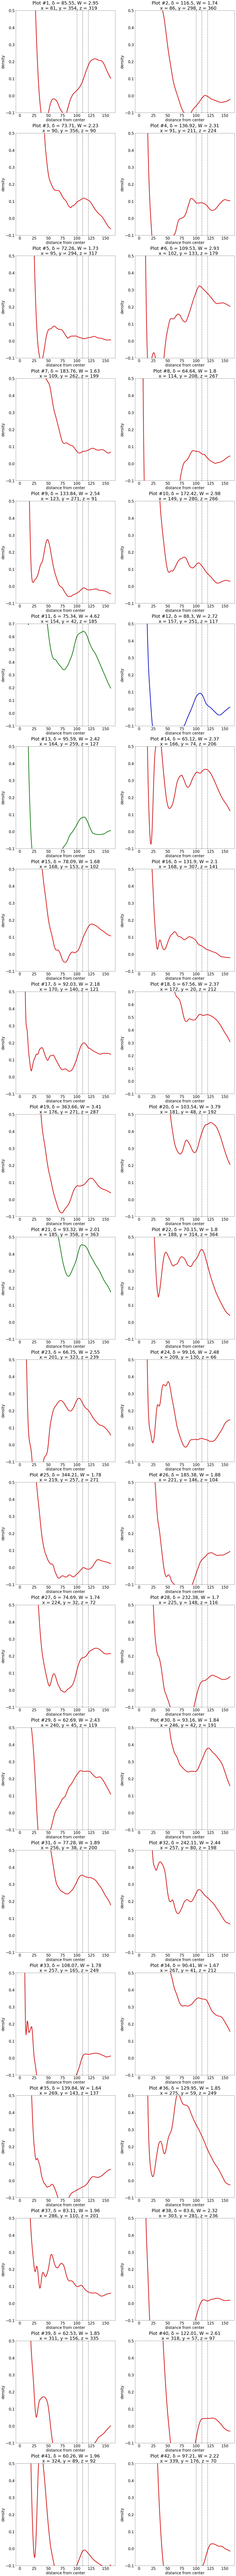

In [48]:
plt.rcParams.update({'font.size': 24})

plt.figure(figsize = (25,300))
for i in range(len(avg_list_pointsT)):
    plt.subplot(21,2,i+1)
    if i == 10 or i == 12 or i == 20:
        plt.plot(Rlist,avg_list_pointsT[i], linewidth = 4, color = 'green')
    elif i == 11:
        plt.plot(Rlist,avg_list_pointsT[i], linewidth = 4, color = 'blue')
    else:
        plt.plot(Rlist,avg_list_pointsT[i], linewidth = 4, color = 'red')
    plt.axvline(x = 100, linestyle = ':', linewidth = 4, color = 'black', alpha = .5)
    plt.axvline(x = 110, linestyle = ':', linewidth = 4, color = 'black', alpha = .5)
    plt.axvline(x = 120, linestyle = ':', linewidth = 4, color = 'black', alpha = .5)
    plt.xlabel('distance from center')
    plt.ylabel('density')
    x,y,z = coords2T[i]
    plt.title(f'Plot #{i+1}, δ = {round(δ[x,y,z],2)}, W = {round(W[x,y,z],2)}\n \
    x = {x}, y = {y}, z = {z}')
    if i == 10 or i == 17:
        plt.ylim(-0.1,0.7)
    else:
        plt.ylim(-0.1,0.5)
plt.show()

Only three of the 42 locations end up representing BAO signals, yielding an average matching parameter of 3.02. Even though a location may be above the threshold density and has a large enough matching parameter to suggest the presence of the BAO, it does not mean that it will. So, why are most of the above points _not_ BAOs? We rule out the presence of BAOs around points for a variety of reasons:
1. There is no BAO bump (Ex. plots #5, #7)
2. Appearance of multiple shells (Ex. plots #10, #14, #41)
3. BAO bump is not near the expected location (Ex. plots #30, #36, #37)
4. BAO bump is too broad (Ex. plots #29, #31)

Radial density profile plots of locations that have BAO signals are going to look _extremely_ similar. So we're looking for sets of points that have matching curves, allowing us to throw away points that seem to have BAO bumps that fit our model, but in reality, do not.

Plot #12 is the only plot in blue, and was disregarded because its location is too close to that of plot #13. This was a result of two local maxima being too close together. The latter has a higher density, and thus is more likely to represent a BAO signal.

We also note that the BAO bump occurs at R = 110, and not R = 117, like our wavelet predicted. However, the result of R = 110 is well within two standard deviations of our result from the wavelet transformation, and is thus deemed to be consistent. Additionally, Arnalte's radial density profile plots have a maximum that occur at R = 119.5, extremely close to our own [9].

Although R is easily determined from the radial density profile plots, both its uncertainty, and the width of shell, are difficult to determine. Both the wavelet transformation and the radial density profile plots are different methods of determining the characteristic parameters of the BAO, and obtaining only an R value from the plots is not an issue for us.

As a final calculation, we determine how likely it is that our results were due to random chance. That is, how likely is it to receive a matching parameter of 3.02 by sampling random locations in the data set?

To compute this probability, we perform 10000 iterations of selecting three points at random from out data set and calculating the average of their matching parameters. Then, we plot our results on a histogram with a fit Gaussian Gaussian curve. By pulling out the standard deviation of the Gaussian fitted to the histogram and using scipy's $\texttt{integrate.quad}$ command, we can determine the probability of our results being due to random chance.

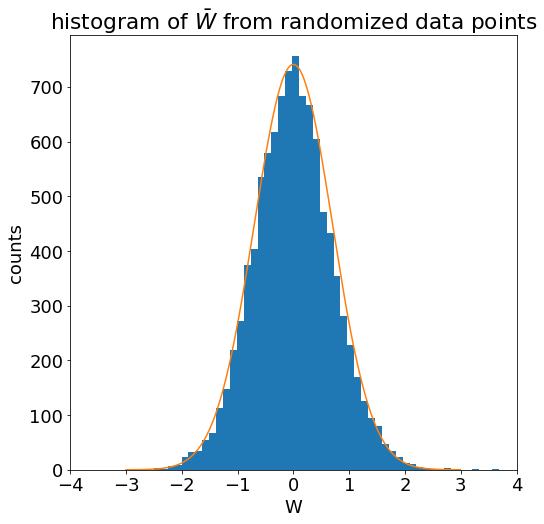

The fitted Gaussian curve has σ = 0.7


In [31]:
plt.rcParams.update({'font.size': 18})

n = 3
def rand_coord():
    return np.random.choice(np.arange(0,400,1))

avg_Wn = []
for i in range(10000):
    Wn = []
    for j in range(n):
        Wn.append(W[rand_coord(),rand_coord(),rand_coord()])
    avg_Wn.append(np.sum(Wn)/n)
WnR = np.linspace(-5,5,len(avg_Wn))

plt.figure(figsize = (8,8))
plt.hist(avg_Wn, bins = 50)
plt.xlim(-4,4)
plt.xlabel('W')
plt.ylabel('counts')
plt.title(r'histogram of $\bar{W}$ from randomized data points')
xlist = np.arange(-3,3,0.01)
plt.plot(xlist, 1300*Gaussian(xlist, 0,0.7))
plt.show()

print ('The fitted Gaussian curve has σ = 0.7')

Scipy's integrate.quad command is used to determine the area under the curve above the average matching parameter of our BAO points, 3.02.

In [60]:
xavg = 0
σ = 0.7
avg_valWpoints = 3.02

P = scipy.integrate.quad(Gaussian,avg_valWpoints,np.inf,args = (0,0.7))[0]
print (f'Probability = {P}')

Probability = 8.00598787789071e-06


Thus, the probability of receiving our results from pure random chance is $8.005 \times 10^{-6}$, or .0008005%, corresponding to 3.41$\sigma$s away! This is great news, as it indicates that there actually _are_ BAOs in the data set, and our results aren't just random artifacts in space.

# Bibliography and References

[1] M. Colless, _First results from the 2dF Galaxy Redshift Survey_, in _Large-
Scale Structure in the Universe_ (G. Efstathiou and et al., eds.), p. 105, 1999.

[2] T. A. Moore, _A General Relativity Workbook_. University Science Books, 2013.

[3] Z. Rostomian. Creative Services, Lawrence Berkeley National Laboratory.

[4] J. P. Huchra, L. M. Macri, K. L. Masters, T. H. Jarrett, P. Berlind, et al.,
_The 2MASS Redshift SurveyDescription and Data Release_, ApJS, vol. 199,
p. 26, Apr. 2012.

[5] E. Aubourg, S. Bailey, J. E. Bautista, F. Beutler, BOSS Collaboration, et al.,
_Cosmological implications of baryon acoustic oscillation measurements_,
Phys. Rev. D, vol. 92, p. 123516, Dec. 2015.

[6] P. W., _Baryon acoustic oscillations: A cosmological ruler_, Physics Today,
vol. 70, 2017.

[7] B. R. Tully, _Galaxy Groups: A 2MASS Catalog,_ aj, vol. 149, p. 171, May
2015.

[8] G. Kaiser, _A Friendly Guide to Wavelets_. Birkhauser, 1994.

[9] P. Arnalte-Mur, A. Labatie, N. Clerc, V. J. Martinez, J.-L. Starck, et al.,
_Wavelet analysis of baryon acoustic structures in the galaxy distribution_,
A&A, vol. 542, p. A34, June 2012.

[10] A. A. Penzias and R. W. Wilson, _A Measurement of Excess Antenna Tem-
perature at 4080 Mc/s._, ApJ, vol. 142, pp. 419-421, July 1965.

[11] A. Font-Ribera, D. Kirkby, N. Busca, J. Miralda-Escude, N. P. Ross, et al.,
_Quasar-Lyman $\alpha$ forest cross-correlation from BOSS DR11: Baryon Acous-
tic Oscillations_, J. Cosmology Astropart. Phys., vol. 5, p. 027, May 2014.

[12] H.-J. Seo and D. J. Eisenstein, _Baryonic Acoustic Oscillations in Simulated
Galaxy Redshift Surveys,_ ApJ, vol. 633, pp. 575{588, Nov. 2005.
26

[13] Kragh and H. Stjernholm, _Expanding earth and static universe : Two papers
of 1935_, 2017.

[14] J. S. Alin and C. L. Starr, _Undergraduate Matrix Theory and Linear Algebra_.
CreateSpace Independent Publishing Platform, 2018.

[15] A. Graps, _An Introduction to Wavelets_. University of Delaware.


[16] J. R. Graham, _Convolution, Correlation, and Fourier Transforms_. 2009.

[17] K. S. Dawson, D. J. Schlegel, C. P. Ahn, and e. a. Anderson, S. F, _The
Baryon Oscillation Spectroscopic Survey of SDSS-III_, AJ, vol. 145, p. 10,
Jan. 2013.